In [59]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [61]:
import warnings

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from deformtools.tools import da_median, get_ci, get_percentiles, alphabet

sns.set(style='ticks', context='paper', palette='colorblind',font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

warnings.simplefilter('ignore')

In [208]:
dat = xr.open_mfdataset('../data/clusters/combinations_lt_10_*.nc',concat_dim='clusters',)
dat = dat.sel(time=slice('2015-09-02 20:00','2015-09-30'))
# dat = dat.where(np.abs(dat.vort)>0.2)

In [209]:
# choose subse
dat = dat.isel(clusters=slice(0,2000))
# average 2h snapshot
# dat = dat.resample(time='3H').mean()

In [210]:
import xrscipy.signal as dsp

In [228]:
def compute_spectra(raw,array):
    raw['dtime'] = ('time', np.array( (raw.time - raw.time.isel(time=0)).values*1e-9, dtype=float))
    raw = raw.swap_dims({'time':'dtime'})
    return dsp.spectrogram(raw[array].dropna(dim='dtime'), dim='dtime', fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )

In [235]:
spec = compute_spectra(dat, 'strain').squeeze()

(0.1, 20.0)

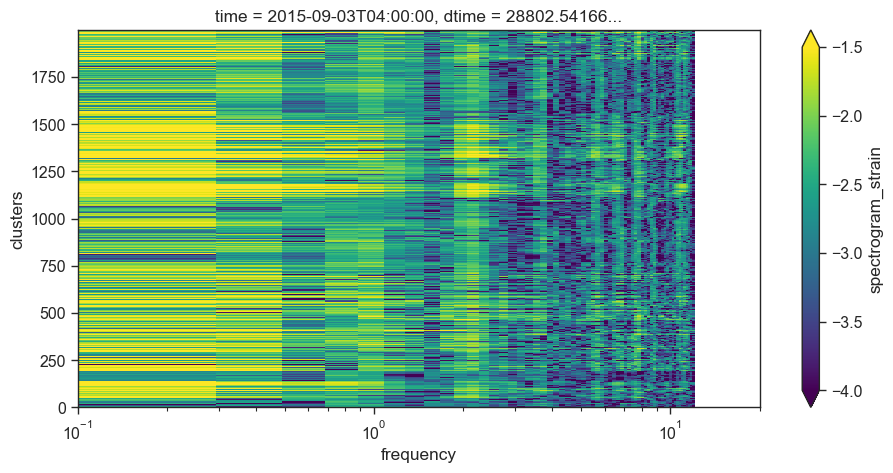

In [236]:
spec.pipe(np.log10).plot(vmin=-4, vmax=-1.5)
plt.xscale('log')
plt.xlim(1e-1,2e1)

In [237]:
import gsw
latmean = dat.lat.mean()

In [238]:
latmean.values

array(17.258696, dtype=float32)

In [239]:
gsw.f(17.4)*86400/(2*np.pi)

0.5997190073327193

In [ ]:
12

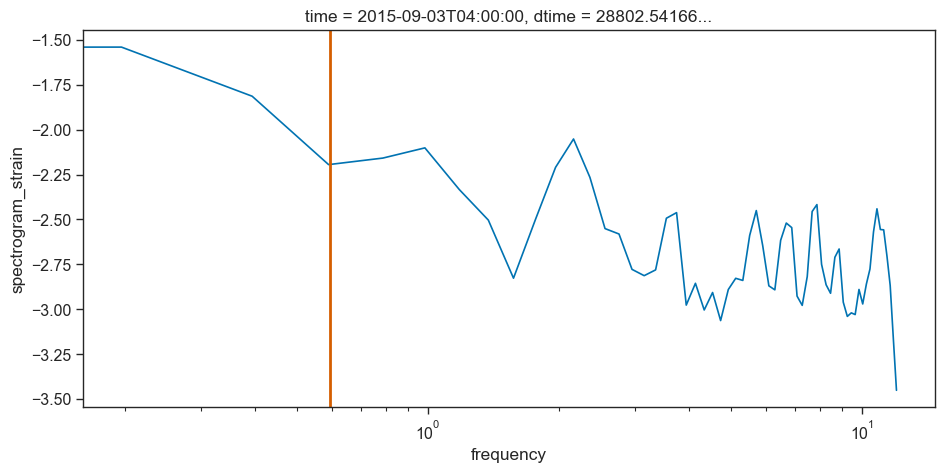

In [240]:
spec.mean(dim='clusters').pipe(np.log10).plot()
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='r')
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='r')
plt.xscale('log')

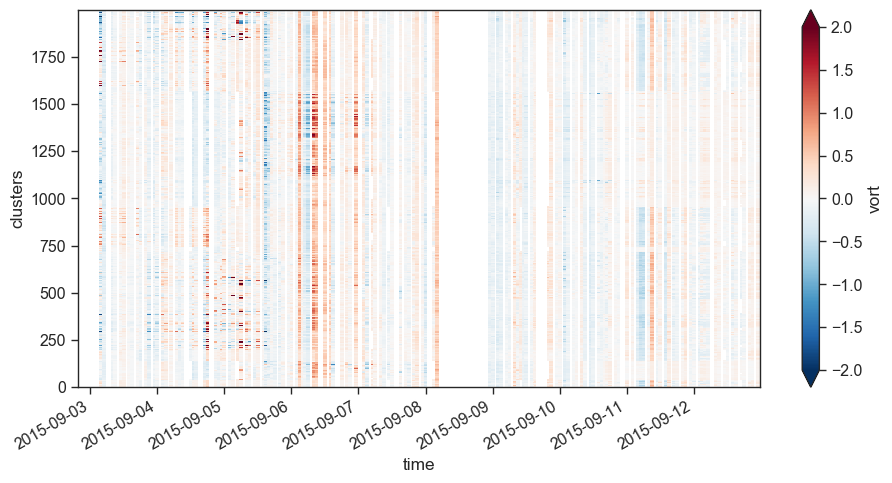

In [217]:
dat.vort.plot(vmin=-2, vmax=2, cmap='RdBu_r')

In [70]:
# running mean filering
periods=10
dat['vort'] = dat.vort #.rolling({'time':periods},center=True).mean()
dat['div'] = dat.div #.rolling({'time':periods},center=True).mean()
dat['strain'] = dat.strain #.rolling({'time':periods},center=True).mean()

In [144]:
dat['mlength'] = ('time', da_median(dat,'length'))
dat['maspect'] = ('time', da_median(dat,'aspect'))
dat['mvort'] = ('time', da_median(dat,'vort'))
dat['mdiv'] = ('time', da_median(dat,'div'))
dat['mstrain'] = ('time', da_median(dat,'strain'))

In [145]:
dat['counts'] = np.isfinite(dat.vort).sum(axis=0)

In [73]:
la, ua = get_ci(dat,'aspect')
ll, ul = get_ci(dat,'length')
ls, us = get_ci(dat,'strain')
lv, uv = get_ci(dat,'vort')
ld, ud = get_ci(dat,'div')

In [74]:
dat['la'] = ('time', la)
dat['ua'] = ('time', ua)
dat['ll'] = ('time', ll)
dat['ul'] = ('time', ul)
dat['ls'] = ('time', ls)
dat['us'] = ('time', us)
dat['lv'] = ('time', lv)
dat['uv'] = ('time', uv)
dat['ld'] = ('time', ld)
dat['ud'] = ('time', ud)

In [75]:
dat.to_netcdf('../data/clusters/timeseries_plot.nc')

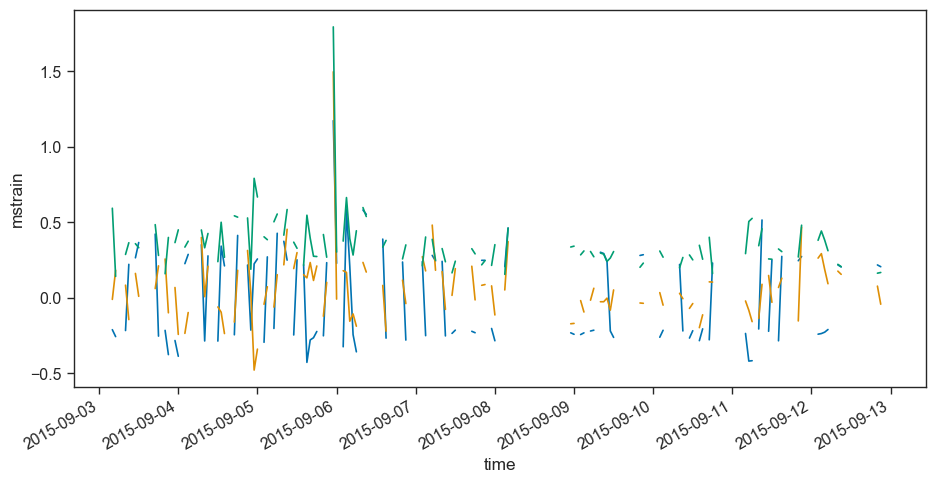

In [146]:
dat.mvort.plot()
dat.mdiv.plot()
dat.mstrain.plot()

In [85]:
f = plt.figure(figsize=(10,15))
widths = [1]
heights = [2,0.3,1,1,1]
spec = f.add_gridspec(ncols=1,
                      nrows=5,
                      width_ratios=widths,
                      height_ratios=heights)


ax0 = f.add_subplot(spec[0, 0])
dat.maspect.plot(ax=ax0, color='k')
ax0.set_xlabel(None)
plt.setp(ax0.get_xticklabels(), visible=False)
# l, u = get_ci(dat,'aspect')
ax0.fill_between(dat.time.values,la,ua,alpha=0.2,zorder=100, color='b')
ax0.tick_params(axis='y', labelcolor='b')
ax0.set_ylabel(r'Aspect ratio $\alpha$')

ax1 = ax0.twinx()
ax1.tick_params(axis='y', labelcolor='g')
dat.mlength.plot(ax=ax1, color='k')
ax1.set_xlabel(None)
ax1.set_ylabel(r'Length scale L')
# plt.setp(ax1.get_xticklabels(), visible=False)
l, u = get_ci(dat,'length')
ax1.fill_between(dat.time.values,ll,ul,alpha=0.2,zorder=100, color='g')

ax0b = f.add_subplot(spec[1, 0],sharex=ax0)
dat.counts.plot(ax=ax0b)
ax0b.set_xlabel(None)
ax0b.set_ylabel(r'# of clusters')
plt.setp(ax0b.get_xticklabels(), visible=False)

ax2 = f.add_subplot(spec[2, 0],sharex=ax0)
dat.mstrain.plot(label='Strain', ax=ax2, color='r')
# l, u = get_ci(dat,'strain')
ax2.fill_between(dat.time.values,ls,us,
                   alpha=0.2, color='r')
# ax2.set_ylabel('Velocity gradients')
ax2.set_ylabel(r'$S$/f')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.set_xlabel(None)
ax2.axhline(0,color='k')
ax2.legend()
           
ax3 = f.add_subplot(spec[3, 0],sharex=ax0)           
dat.mvort.plot(label='Vorticity', ax=ax3, color='k')
# l, u = get_ci(dat,'vort')
ax3.fill_between(dat.time.values,lv,uv,
                   alpha=0.2, color='k')
                                               
ax3.legend()
ax3.axhline(0,color='k')
# ax3.set_ylabel('Velocity gradients')
ax3.set_ylabel(r'$\zeta$/f')
ax3.set_xlabel(None)
ax3.set_ylim(-0.5,0.5)
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = f.add_subplot(spec[4, 0],sharex=ax0)   
dat.mdiv.plot(label='Divergence', ax=ax4, color='b')
# l, u = get_ci(dat,'div')
ax4.fill_between(dat.time.values,ld,ud,
                   alpha=0.2, color='b')  
ax4.axhline(0,color='k')
ax4.set_ylim(-0.5,0.5)
ax4.set_xlabel(None)
ax4.set_ylabel(r'$\delta$/f')
# ax4.legend()

alphabet([ax0,ax0b,ax2,ax3,ax4])

spec.tight_layout(f)
spec.update(hspace=0.18)

plt.savefig('../figures/timeseries_v1.pdf')

ValueError: view limit minimum -36792.69583333333 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11d233c80> (for post_execute):


ValueError: view limit minimum -36792.69583333333 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36792.69583333333 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 1000x1500 with 3 Axes>

In [78]:
f = plt.figure(figsize=(8,10))
widths = [1]
heights = [0.3,1,1,1]
spec = f.add_gridspec(ncols=1,
                      nrows=4,
                      width_ratios=widths,
                      height_ratios=heights)

ax0b = f.add_subplot(spec[0, 0])
dat.counts.plot(ax=ax0b)
ax0b.set_xlabel(None)
ax0b.set_ylabel(r'# of clusters')
ax0b.set_yticks([0,10000,20000,30000])
plt.setp(ax0b.get_xticklabels(), visible=False)

ax2 = f.add_subplot(spec[1, 0],sharex=ax0b)
dat.mdiv.plot(ax=ax2, color='b')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.set_xlabel(None)
ax2.fill_between(dat.time.values,ld,ud,
                   alpha=0.2, color='b')  
ax2.axhline(0,color='k')
ax2.set_ylim(-0.5,0.5)
        
ax3 = f.add_subplot(spec[2, 0],sharex=ax0b)           
dat.mvort.plot(ax=ax3, color='k')
ax3.fill_between(dat.time.values,lv,uv,
                   alpha=0.2, color='k')
ax3.axhline(0,color='k')
ax3.set_ylabel(r'Vorticity $\zeta$/f')
ax3.set_xlabel(None)
ax3.set_ylim(-0.5,0.5)
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = f.add_subplot(spec[3, 0],sharex=ax0b)   
dat.mstrain.plot(ax=ax4, color='r')
ax4.fill_between(dat.time.values,ls,us,
                   alpha=0.2, color='r')
ax4.set_ylabel(r'Lateral strain rate $S$/f')
ax4.set_ylim(0,1)
ax4.set_xlabel(None)
ax4.set_ylabel(r'Divergence $\delta$/f')
ax4.set_xlim('2015-09-03','2015-09-12')

alphabet([ax0b,ax2,ax3,ax4])

spec.tight_layout(f)
spec.update(hspace=0.18)

plt.savefig('../figures/timeseries_v2.pdf')

ValueError: view limit minimum -36792.69583333333 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11d233c80> (for post_execute):


ValueError: view limit minimum -36792.69583333333 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36792.69583333333 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 800x1000 with 2 Axes>

In [79]:
import gsw
ff = gsw.f(18)

In [80]:
def timef(df):
    import gsw
    ff = gsw.f(18)
    return df*ff

def divf(df):
    import gsw
    ff = gsw.f(18)
    return df/ff

In [81]:
deriv = -dat.mvort.pipe(timef).differentiate('time',datetime_unit='s')/(ff+dat.mvort*ff)

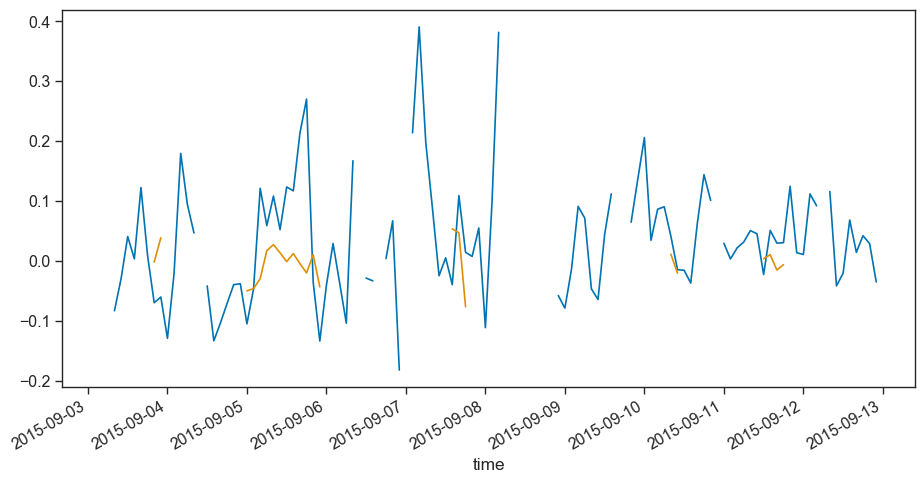

In [82]:
dat.mdiv.plot()
deriv.pipe(divf).rolling({'time':10},center=True).mean().plot()

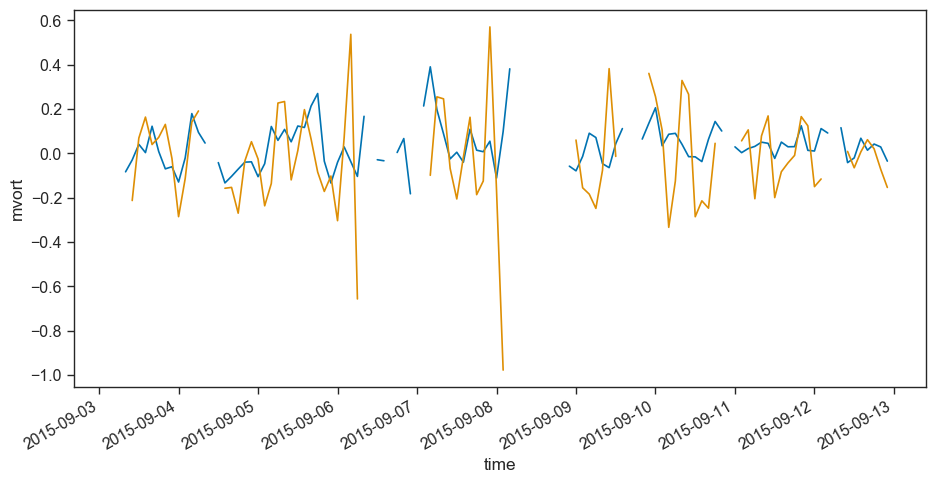

In [83]:
dat.mdiv.plot()
deriv.pipe(divf).plot()

In [84]:
2*np.pi/gsw.f(17)/3600

40.93158129292459